In [22]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [24]:
# Load datasets
df1 = pd.read_csv('/Users/atrabaja/Documents/FinMark_MachineLearning/customernew.csv', encoding='ISO-8859-1')
df2 = pd.read_csv('/Users/atrabaja/Documents/FinMark_MachineLearning/productnew.csv', encoding='ISO-8859-1')
df3 = pd.read_csv('/Users/atrabaja/Documents/FinMark_MachineLearning/transactionsnew.csv', encoding='ISO-8859-1')

In [26]:
# # Step 1: Data Preprocessing

# Handling Missing Values:
# Company_Profit in the customer dataset is imputed with the median.
# Rows with missing Product_ID in the product dataset are dropped.
# Product_Price strings are cleaned by removing commas and converted to floats.
# Invalid Quantity entries in the transactions dataset are coerced into NaN and dropped.
# Date Conversion:
# Transaction_Date is converted into datetime format for temporal analysis.

# 1.1 Handle missing values
# Customer Dataset - Impute missing Company_Profit with median
df1['Company_Profit'] = df1['Company_Profit'].fillna(df1['Company_Profit'].median())

# Product Dataset - Drop rows with missing Product_ID and clean Product_Price
df2 = df2.dropna(subset=['Product_ID'])
df2['Product_Price'] = df2['Product_Price'].str.replace(',', '').astype(float)

# Transactions Dataset - Clean Quantity and drop rows with critical missing values
df3['Quantity'] = pd.to_numeric(df3['Quantity'], errors='coerce')
df3 = df3.dropna(subset=['Transaction_ID', 'Company_ID', 'Product_ID', 'Product_Price', 'Total_Cost'])

# 1.2 Convert Transaction_Date to datetime format
df3['Transaction_Date'] = pd.to_datetime(df3['Transaction_Date'], format='%d-%m-%Y')

Customer Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Company_ID      100 non-null    int64  
 1   Company_Name    100 non-null    object 
 2   Company_Profit  100 non-null    float64
 3   City            100 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.3+ KB
None
   Company_ID        Company_Name  Company_Profit    City
0           1    Tech Enterprises         80701.0   Pasig
1           2     Global Partners         80511.0  Taguig
2           3  Quantum Associates        110664.0   Pasig
3           4       Prime Network         75301.5  Taguig
4           5      Elite Ventures         69427.0  Makati

Product Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, 0 to 19
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         -----

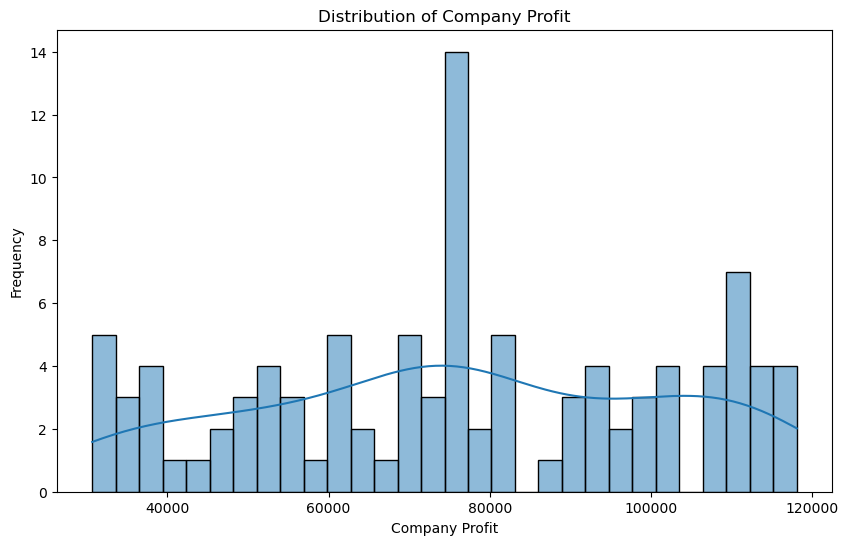

In [28]:
# Step 2: Exploratory Data Analysis (EDA)

# Data Overview:
# Display .info() and .head() to understand dataset structure.
# Check for missing values across datasets.
# Visualizations:
# Histogram: Displays the distribution of Company_Profit to detect skewness or outliers.
# Correlation Heatmap: Visualizes correlations between numerical features like Total_Spent, Recency, and Avg_Purchase_Value.
# Purchase Behavior Count Plot: Shows how many companies purchased recently (Purchased_Recently).

# Checking structure and previewing data
print("Customer Dataset Info:")
print(df1.info())
print(df1.head())

print("\nProduct Dataset Info:")
print(df2.info())
print(df2.head())

print("\nTransactions Dataset Info:")
print(df3.info())
print(df3.head())

# Checking for missing values
print("\nMissing Values in Customer Dataset:")
print(df1.isnull().sum())

print("\nMissing Values in Product Dataset:")
print(df2.isnull().sum())

print("\nMissing Values in Transactions Dataset:")
print(df3.isnull().sum())

# Visualizing distribution of Company Profit
plt.figure(figsize=(10, 6))
sns.histplot(df1['Company_Profit'], bins=30, kde=True)
plt.title('Distribution of Company Profit')
plt.xlabel('Company Profit')
plt.ylabel('Frequency')
plt.show()

In [30]:
# Step 3: Feature Engineering

# Merging Datasets:

# Combine transactions, customers, and product datasets for enriched feature sets.
# New Features:
# Total_Transactions: Total transactions made by each company.
# Total_Spent: Total amount spent by each company.
# Avg_Purchase_Value: Average transaction value per company.
# Recency: Days since the last transaction, a key predictor of purchasing likelihood.
# Target Variable:
# Purchased_Recently: Binary classification where 1 indicates a purchase in the last 180 days and 0 otherwise.

# 3.1 Merge datasets
merged_df = df3.merge(df1, on='Company_ID', how='left')
merged_df = merged_df.merge(df2, on='Product_ID', how='left')

# 3.2 Create new features
# Total Transactions per Customer
customer_transactions = merged_df.groupby('Company_ID').agg({
    'Transaction_ID': 'count',
    'Total_Cost': 'sum',
    'Transaction_Date': 'max'
}).rename(columns={'Transaction_ID': 'Total_Transactions', 'Total_Cost': 'Total_Spent'})

# Average Purchase Value
customer_transactions['Avg_Purchase_Value'] = customer_transactions['Total_Spent'] / customer_transactions['Total_Transactions']

# Recency (days since last purchase)
latest_date = merged_df['Transaction_Date'].max()
customer_transactions['Recency'] = (latest_date - customer_transactions['Transaction_Date']).dt.days

# Merge features back with customer data
final_df = df1.merge(customer_transactions, on='Company_ID', how='left').fillna(0)

# 3.3 Define target variable
# If a customer made a purchase in the last 180 days, label as 1, else 0
final_df['Purchased_Recently'] = np.where(final_df['Recency'] <= 180, 1, 0)

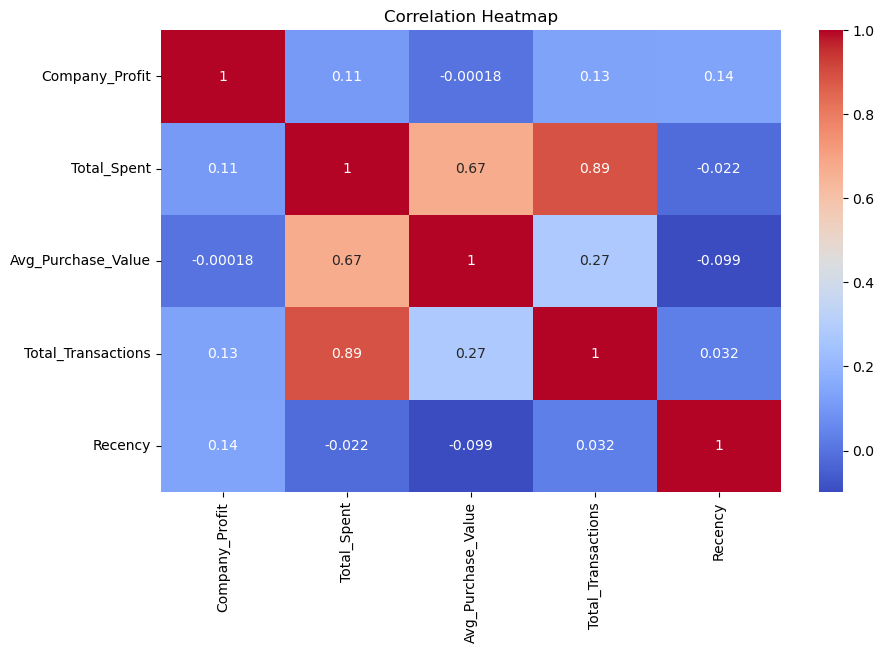

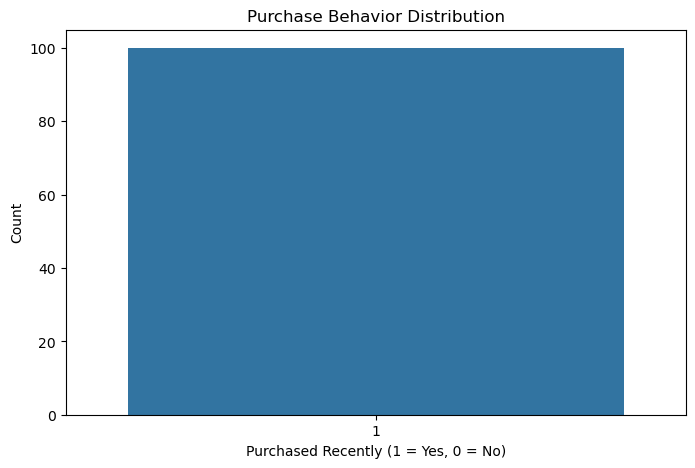

In [32]:
# Step 4: Correlation Analysis
# Heatmap: Visualizes correlations between key features (Recency, Total_Spent, etc.) to detect multicollinearity or influential predictors.

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(final_df[['Company_Profit', 'Total_Spent', 'Avg_Purchase_Value', 'Total_Transactions', 'Recency']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Visualizing purchase behavior
plt.figure(figsize=(8, 5))
sns.countplot(x='Purchased_Recently', data=final_df)
plt.title('Purchase Behavior Distribution')
plt.xlabel('Purchased Recently (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

In [34]:
# Step 5: Model Selection and Training
# Pipeline Setup:
# Numerical features are imputed using median values.
# Categorical features (City) are one-hot encoded.
# Model:
# A RandomForestClassifier is chosen for its ability to handle non-linear relationships and feature importance extraction.
# Data Splitting:
# Stratified train-test split ensures balanced representation of both classes in training and testing datasets.

# 5.1 Prepare features and target
features = final_df[['Company_Profit', 'Total_Transactions', 'Total_Spent', 'Avg_Purchase_Value', 'Recency', 'City']]
target = final_df['Purchased_Recently']

# One-hot encode categorical feature 'City'
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), ['Company_Profit', 'Total_Transactions', 'Total_Spent', 'Avg_Purchase_Value', 'Recency']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['City'])
    ])

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 5.2 Split data into train and test sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42, stratify=target
)

# 5.3 Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Company_Profit',
                                                   'Total_Transactions',
                                                   'Total_Spent',
                                                   'Avg_Purchase_Value',
                                                   'Recency']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['City'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [36]:
# Step 6: Model Evaluation
# Predictions:
# The model predicts whether a company is likely to purchase again.
# Evaluation Metrics:
# Classification Report: Provides precision, recall, and F1-score.
# Confusion Matrix: Shows the model's correct and incorrect predictions.
# ROC-AUC Score: Evaluates how well the model distinguishes between classes, calculated only when both classes are present in y_test.
# Accuracy Score: Measures overall correctness of the model.
# Feature Importance:
# Highlights which features most influence the model's predictions, guiding further feature engineering.

# 6.1 Make predictions
y_pred = pipeline.predict(X_test)

# Check if model supports probability prediction for both classes
if len(np.unique(y_test)) == 2:
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability for the positive class

    # 6.2 Evaluate model performance
    print("Classification Report:\n", classification_report(y_test, y_pred, labels=[0, 1], zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=[0, 1]))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
else:
    print("Only one class present in y_test. ROC-AUC Score cannot be calculated.")
    print("Classification Report:\n", classification_report(y_test, y_pred, labels=[0, 1], zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=[0, 1]))

# Additional Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy Score: {accuracy:.2f}')

# 6.3 Feature importance analysis (for Random Forest)
feature_names = (
    pipeline.named_steps['preprocessor'].transformers_[0][2] + 
    list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(['City']))
)
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Display feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

Only one class present in y_test. ROC-AUC Score cannot be calculated.
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00        30

    accuracy                           1.00        30
   macro avg       0.50      0.50      0.50        30
weighted avg       1.00      1.00      1.00        30

Confusion Matrix:
 [[ 0  0]
 [ 0 30]]
Accuracy Score: 1.00
               Feature  Importance
0       Company_Profit         0.0
1   Total_Transactions         0.0
2          Total_Spent         0.0
3   Avg_Purchase_Value         0.0
4              Recency         0.0
5          City_Baguio         0.0
6            City_Cebu         0.0
7           City_Davao         0.0
8          City_Makati         0.0
9     City_Mandaluyong         0.0
10         City_Manila         0.0
11     City_ParaÃ±aque         0.0
12          City_Pasig         0.0
13         City_Quezon        

In [42]:
# Step 7: Conclusion
# Insights:
# The RandomForestClassifier identifies key predictors of customer purchasing behavior.
# Performance metrics indicate how well the model generalizes to unseen data.
# Next Steps:
# Hyperparameter Tuning: Further optimization using GridSearchCV.
# Feature Refinement: Introduce additional variables or refine existing ones based on feature importance.

# The RandomForestClassifier provides insights into customer purchase likelihood based on recency and spending behavior.
# Performance metrics guide further feature engineering or hyperparameter tuning to improve model accuracy.

Customer Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Company_ID      100 non-null    int64  
 1   Company_Name    100 non-null    object 
 2   Company_Profit  100 non-null    float64
 3   City            100 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.3+ KB
None
   Company_ID        Company_Name  Company_Profit    City
0           1    Tech Enterprises         80701.0   Pasig
1           2     Global Partners         80511.0  Taguig
2           3  Quantum Associates        110664.0   Pasig
3           4       Prime Network         75301.5  Taguig
4           5      Elite Ventures         69427.0  Makati

Product Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, 0 to 19
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         -----

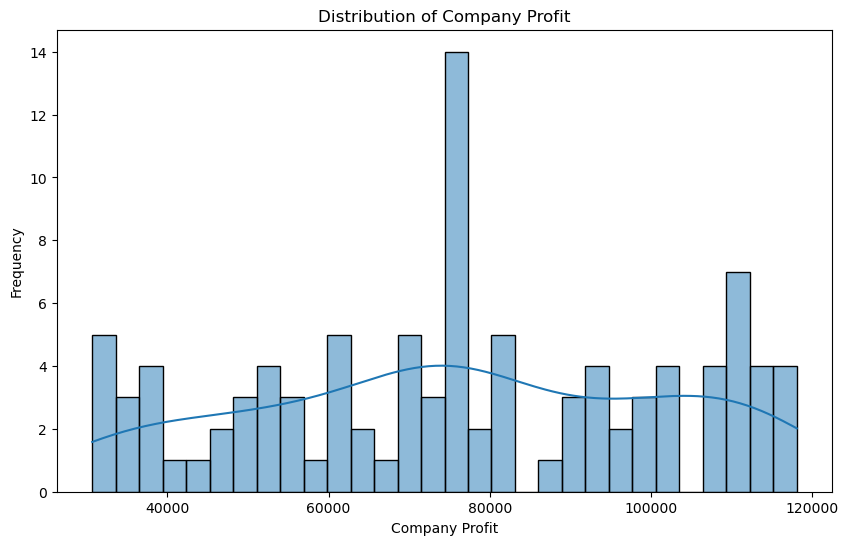

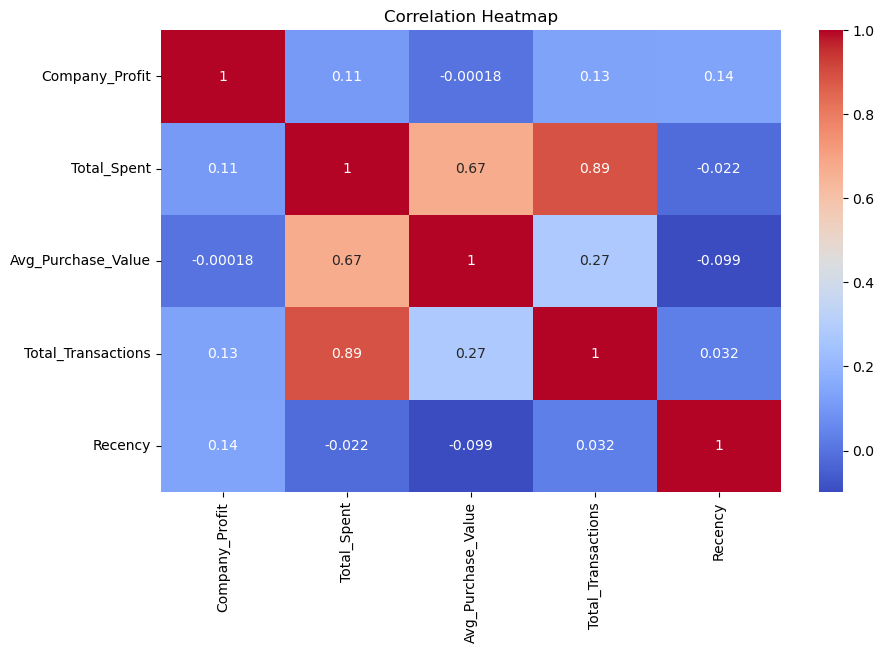

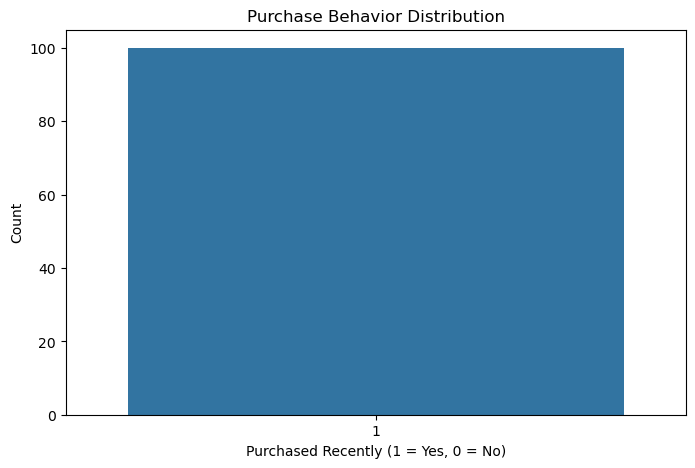

Only one class present in y_test. ROC-AUC Score cannot be calculated.
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00        30

    accuracy                           1.00        30
   macro avg       0.50      0.50      0.50        30
weighted avg       1.00      1.00      1.00        30

Confusion Matrix:
 [[ 0  0]
 [ 0 30]]
Accuracy Score: 1.00
               Feature  Importance
0       Company_Profit         0.0
1   Total_Transactions         0.0
2          Total_Spent         0.0
3   Avg_Purchase_Value         0.0
4              Recency         0.0
5          City_Baguio         0.0
6            City_Cebu         0.0
7           City_Davao         0.0
8          City_Makati         0.0
9     City_Mandaluyong         0.0
10         City_Manila         0.0
11     City_ParaÃ±aque         0.0
12          City_Pasig         0.0
13         City_Quezon        

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load datasets
df1 = pd.read_csv('/Users/atrabaja/Documents/FinMark_MachineLearning/customernew.csv', encoding='ISO-8859-1')
df2 = pd.read_csv('/Users/atrabaja/Documents/FinMark_MachineLearning/productnew.csv', encoding='ISO-8859-1')
df3 = pd.read_csv('/Users/atrabaja/Documents/FinMark_MachineLearning/transactionsnew.csv', encoding='ISO-8859-1')

# Step 1: Data Preprocessing

# 1.1 Handle missing values
# Customer Dataset - Impute missing Company_Profit with median
df1['Company_Profit'] = df1['Company_Profit'].fillna(df1['Company_Profit'].median())

# Product Dataset - Drop rows with missing Product_ID and clean Product_Price
df2 = df2.dropna(subset=['Product_ID'])
df2['Product_Price'] = df2['Product_Price'].str.replace(',', '').astype(float)

# Transactions Dataset - Clean Quantity and drop rows with critical missing values
df3['Quantity'] = pd.to_numeric(df3['Quantity'], errors='coerce')
df3 = df3.dropna(subset=['Transaction_ID', 'Company_ID', 'Product_ID', 'Product_Price', 'Total_Cost'])

# 1.2 Convert Transaction_Date to datetime format
df3['Transaction_Date'] = pd.to_datetime(df3['Transaction_Date'], format='%d-%m-%Y')

# Step 2: Exploratory Data Analysis (EDA)

# Checking structure and previewing data
print("Customer Dataset Info:")
print(df1.info())
print(df1.head())

print("\nProduct Dataset Info:")
print(df2.info())
print(df2.head())

print("\nTransactions Dataset Info:")
print(df3.info())
print(df3.head())

# Checking for missing values
print("\nMissing Values in Customer Dataset:")
print(df1.isnull().sum())

print("\nMissing Values in Product Dataset:")
print(df2.isnull().sum())

print("\nMissing Values in Transactions Dataset:")
print(df3.isnull().sum())

# Visualizing distribution of Company Profit
plt.figure(figsize=(10, 6))
sns.histplot(df1['Company_Profit'], bins=30, kde=True)
plt.title('Distribution of Company Profit')
plt.xlabel('Company Profit')
plt.ylabel('Frequency')
plt.show()

# Step 3: Feature Engineering

# 3.1 Merge datasets
merged_df = df3.merge(df1, on='Company_ID', how='left')
merged_df = merged_df.merge(df2, on='Product_ID', how='left')

# 3.2 Create new features
# Total Transactions per Customer
customer_transactions = merged_df.groupby('Company_ID').agg({
    'Transaction_ID': 'count',
    'Total_Cost': 'sum',
    'Transaction_Date': 'max'
}).rename(columns={'Transaction_ID': 'Total_Transactions', 'Total_Cost': 'Total_Spent'})

# Average Purchase Value
customer_transactions['Avg_Purchase_Value'] = customer_transactions['Total_Spent'] / customer_transactions['Total_Transactions']

# Recency (days since last purchase)
latest_date = merged_df['Transaction_Date'].max()
customer_transactions['Recency'] = (latest_date - customer_transactions['Transaction_Date']).dt.days

# Merge features back with customer data
final_df = df1.merge(customer_transactions, on='Company_ID', how='left').fillna(0)

# 3.3 Define target variable
# If a customer made a purchase in the last 180 days, label as 1, else 0
final_df['Purchased_Recently'] = np.where(final_df['Recency'] <= 180, 1, 0)

# Step 4: Correlation Analysis

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(final_df[['Company_Profit', 'Total_Spent', 'Avg_Purchase_Value', 'Total_Transactions', 'Recency']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Visualizing purchase behavior
plt.figure(figsize=(8, 5))
sns.countplot(x='Purchased_Recently', data=final_df)
plt.title('Purchase Behavior Distribution')
plt.xlabel('Purchased Recently (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

# Step 5: Model Selection and Training

# 5.1 Prepare features and target
features = final_df[['Company_Profit', 'Total_Transactions', 'Total_Spent', 'Avg_Purchase_Value', 'Recency', 'City']]
target = final_df['Purchased_Recently']

# One-hot encode categorical feature 'City'
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), ['Company_Profit', 'Total_Transactions', 'Total_Spent', 'Avg_Purchase_Value', 'Recency']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['City'])
    ])

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 5.2 Split data into train and test sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42, stratify=target
)

# 5.3 Train the model
pipeline.fit(X_train, y_train)

# Step 6: Model Evaluation

# 6.1 Make predictions
y_pred = pipeline.predict(X_test)

# Check if model supports probability prediction for both classes
if len(np.unique(y_test)) == 2:
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability for the positive class

    # 6.2 Evaluate model performance
    print("Classification Report:\n", classification_report(y_test, y_pred, labels=[0, 1], zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=[0, 1]))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
else:
    print("Only one class present in y_test. ROC-AUC Score cannot be calculated.")
    print("Classification Report:\n", classification_report(y_test, y_pred, labels=[0, 1], zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=[0, 1]))

# Additional Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy Score: {accuracy:.2f}')

# 6.3 Feature importance analysis (for Random Forest)
feature_names = (
    pipeline.named_steps['preprocessor'].transformers_[0][2] + 
    list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(['City']))
)
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Display feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Step 7: Conclusion
# The RandomForestClassifier provides insights into customer purchase likelihood based on recency and spending behavior. Performance metrics guide further feature engineering or hyperparameter tuning to improve model accuracy.
